# 🧩 Customer Segmentation (Clustering)
### Using All Demographic, Behavioral, Policy, Financial, and Risk Features

This notebook performs unsupervised clustering to identify meaningful customer segments.
We use:
- K-Means
- DBSCAN
- Hierarchical Clustering
- PCA for visualization

All features from the processed dataset are included.

## 📦 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set(style="whitegrid")
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

## 📁 Load Preprocessed Dataset

In [2]:
df = pd.read_csv("../data/processed_customer_dataset.csv")
df.head()

,Customer ID,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,...,Driving Record_Major Violations,Driving Record_Minor Violations,Life Events_Divorce,Life Events_Job Change,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5
0,1.161055,-1.401980,-0.333617,-0.636458,1.416283,-0.469361,-0.213640,0.871878,-0.525889,1.212606,...,False,False,False,True,False,False,False,False,False,True
1,1.537483,-1.203033,-0.780348,0.377921,-1.441872,1.071729,-0.822588,0.587999,-0.525889,0.301218,...,False,False,False,False,False,True,False,False,False,True
2,-1.481328,-1.004085,-0.241996,-0.020824,0.844652,1.048219,1.080474,0.886162,0.354840,-0.610170,...,False,False,False,False,False,False,False,True,False,False
3,0.879390,-1.600928,-0.528975,-1.216311,1.416283,1.099966,1.025256,1.252169,1.235569,-1.521558,...,False,False,False,True,False,False,False,True,False,False
4,1.274459,-1.269349,-1.199821,1.541248,0.273021,-0.469722,-1.359210,-1.754449,-1.406619,1.212606,...,True,False,False,False,False,False,True,False,False,False


## 🔧 Prepare Feature Matrix for Clustering
Using all features.

In [3]:
X = df.copy()  # all features included
X.shape

(53503, 2123)

## 🎯 K-Means Clustering
We will:
- Use Elbow Method to find optimal K
- Fit K-Means
- Evaluate using Silhouette Score

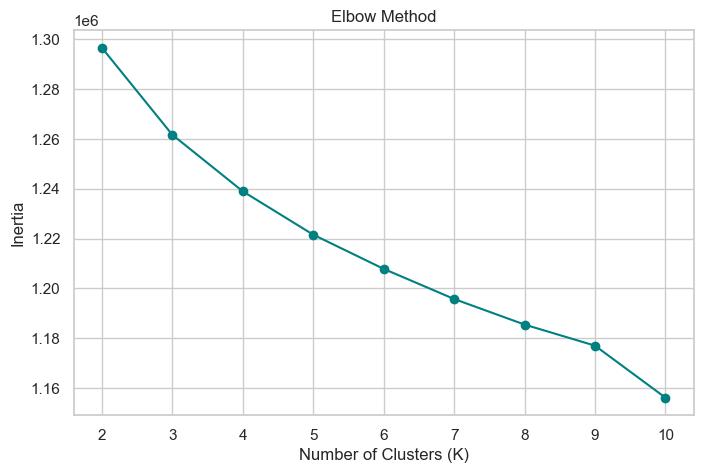

In [4]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', color="teal")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

In [5]:
optimal_k = 5  # choose based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(X)

sil_score = silhouette_score(X, df["KMeans_Cluster"])
sil_score

0.02488839177027667

## 🎨 PCA Visualization (2D)

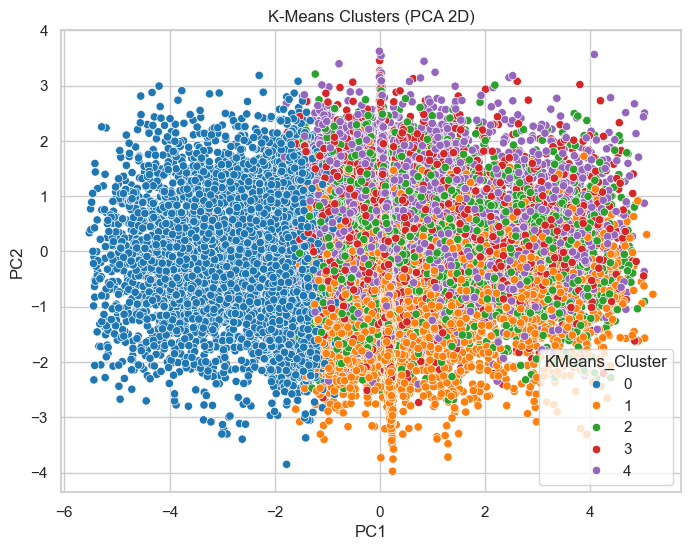

In [6]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

df["PC1"] = pca_components[:, 0]
df["PC2"] = pca_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="KMeans_Cluster",
    palette="tab10",
    data=df
)
plt.title("K-Means Clusters (PCA 2D)")
plt.show()

## 🌀 DBSCAN Clustering
Useful for detecting outliers and irregular cluster shapes.

In [7]:
dbscan = DBSCAN(eps=2.5, min_samples=10)
df["DBSCAN_Cluster"] = dbscan.fit_predict(X)

df["DBSCAN_Cluster"].value_counts()

DBSCAN_Cluster
-1    53503
Name: count, dtype: int64

## 🎨 DBSCAN Visualization (PCA 2D)

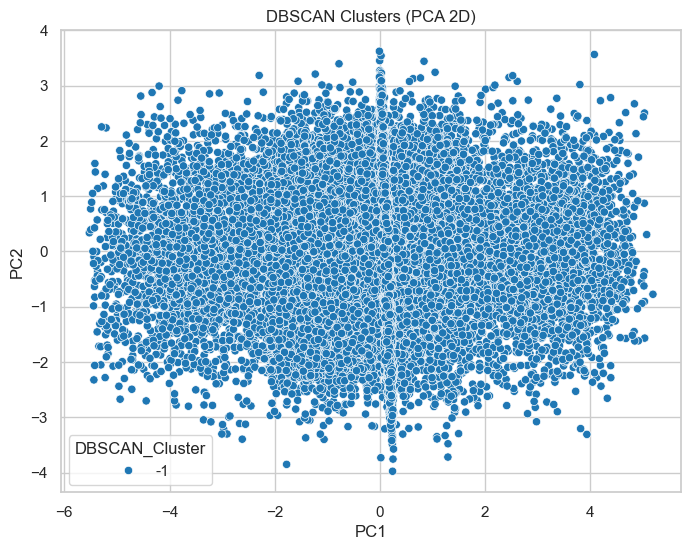

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="DBSCAN_Cluster",
    palette="tab10",
    data=df
)
plt.title("DBSCAN Clusters (PCA 2D)")
plt.show()

## 🌳 Hierarchical Clustering (Agglomerative)

In [9]:
# Reduce dimensions before hierarchical clustering
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

hier = AgglomerativeClustering(n_clusters=4, linkage="single")
df["Hier_Cluster"] = hier.fit_predict(X_pca)

df["Hier_Cluster"].value_counts()

Hier_Cluster
0    53500
3        1
2        1
1        1
Name: count, dtype: int64

## 🌿 Dendrogram (Hierarchical Clustering)

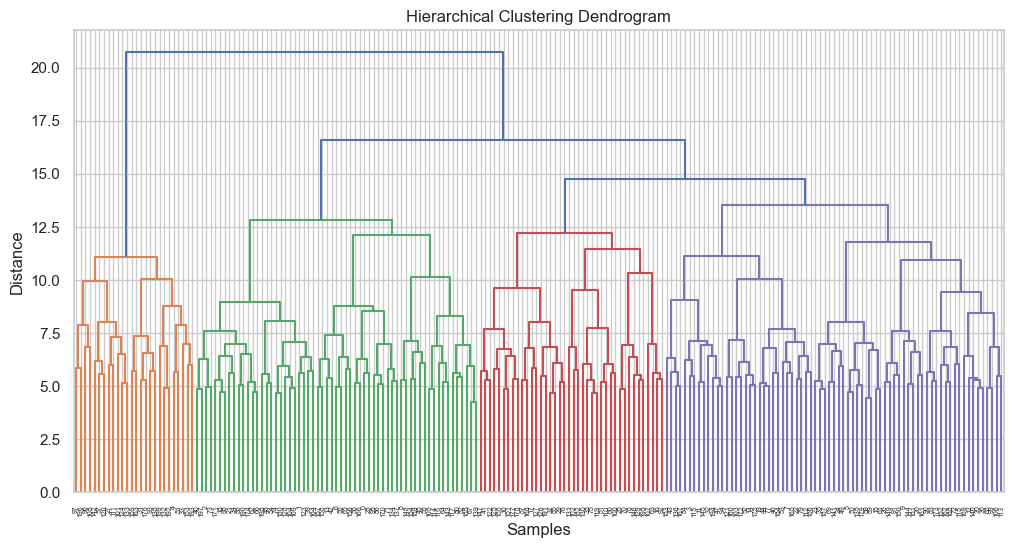

In [10]:
plt.figure(figsize=(12,6))
linkage_matrix = linkage(X.sample(200), method='ward')  # sample for speed
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

## 🧠 Cluster Profiling
Analyze average values per cluster to understand customer groups.

In [11]:
cluster_profile = df.groupby("KMeans_Cluster").mean()
cluster_profile

,Customer ID,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,...,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5,PC1,PC2,DBSCAN_Cluster,Hier_Cluster
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.006865,-0.035086,0.003610,-0.036400,-0.027472,-0.006031,-0.008476,0.003646,0.007405,0.016107,...,0.250417,0.171489,0.206787,0.176488,0.193153,0.267687,-2.383691,-0.072272,-1.0,0.000151
1,0.040768,0.075927,0.077269,0.068527,0.709111,0.003813,-0.107709,-0.165355,-0.972618,-0.085553,...,0.236803,0.165005,0.208826,0.174202,0.187650,0.258830,0.356956,-0.714336,-1.0,0.000386
2,-0.012418,-0.188679,0.050143,0.007691,0.047957,0.029131,0.034002,-0.992852,0.854188,-0.065863,...,0.239796,0.168065,0.207842,0.159110,0.189085,0.269111,0.365436,0.062924,-1.0,0.000000
3,-0.109595,0.041995,-0.194124,-0.014966,0.591592,0.002090,0.079936,0.881687,0.744307,0.100239,...,0.263471,0.170246,0.224424,0.183913,0.176494,0.275185,0.294470,0.270897,-1.0,0.000000
4,0.051992,0.062599,0.033031,-0.043834,-1.187101,-0.025934,0.020595,0.275867,-0.316624,0.051299,...,0.267201,0.179558,0.218993,0.174371,0.198932,0.243021,0.322092,0.478813,-1.0,0.000000


## 💾 Save Segmented Dataset

In [12]:
df.to_csv("../data/segmented_customers.csv", index=False)
print("Segmented dataset saved successfully!")

Segmented dataset saved successfully!


## ✅ Next Steps

- Build customer personas from cluster profiles  
- Integrate segmentation into Streamlit dashboard  
- Use clusters to enhance fraud detection  
- Add t-SNE visualization for deeper insights  